In [112]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
import shap
# Отключаем все предупреждения
warnings.filterwarnings("ignore")

np.random.seed(777)

In [113]:
# Чтение данных
teacher_info = pd.read_feather("./data/teachers_info.feather") 

teachers = pd.read_feather("./data/teachers.feather")

lesson_course = pd.read_feather("./data/lesson_course.feather")

lessons = pd.read_feather("./data/lessons.feather")

teacher_prices = pd.read_feather("./data/teacher_prices.feather")

orders = pd.read_feather("./data/orders.feather")

## Важность сохранения исходных данных перед аггрегацией признаков

При подготовке данных для машинного обучения возникает вопрос о необходимости предварительной очистки данных перед их агрегацией. Однако очистка исходных данных до аггрегации может не всегда быть лучшим решением по следующим причинам:

- **Потеря информации**: Предварительное удаление данных может привести к потере важной информации, которая могла бы быть полезной при создании новых признаков или во время анализа. Даже выбросы или аномалии могут нести в себе ценную информацию о поведении системы или о необычных паттернах.

- **Искажение статистик**: Аггрегация должна отражать реальные распределения в данных, и предварительная чистка может исказить эти распределения, приводя к некорректным статистическим выводам.

- **Смещение модели**: Если очистка данных не отражает реальные условия, в которых будет работать модель, это может привести к смещению модели и ухудшению ее предсказательной способности на реальных данных.

- **Возможность восстановления**: Исходные данные могут содержать ошибки, но с ними можно работать путем восстановления или импутации, что бывает невозможно после удаления.

- **Аггрегация с учетом пропусков**: Современные методы аггрегации могут учитывать пропуски данных, используя такие методы, как заполнение медианой или средним, или даже использование моделей машинного обучения для предсказания отсутствующих значений.

Таким образом, сохранение исходных данных и их аггрегация без предварительной чистки позволяет создать более точные и устойчивые модели, которые лучше работают в условиях реальной эксплуатации.


In [114]:
merged_df = pd.merge(lesson_course, lessons, left_on='id', right_on='lesson_course_id', how='inner')
merged_df = merged_df.rename(columns={'id_x': 'id_lesson_course', 'id_y': 'id_lesson'})
merged_df

,id_lesson_course,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_lesson,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,1614162,242243,2021-12-02 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,2078365,242243,2022-05-20 00:00:00.000,11:00:00,12:00:00,NaN,0,NaN,NaN
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1849169,242364,2021-10-05 00:00:00.000,18:00:00,19:00:00,NaN,1,NaN,NaN
3,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1885812,242364,2021-10-16 00:00:00.000,18:00:00,19:00:00,NaN,0,NaN,NaN
4,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1929732,242364,2021-10-22 00:00:00.000,18:00:00,19:00:00,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126432,1471853,1252494.0,211703,2892464.0,4,1500,1,60,2023-10-18 12:56:15.447,1800-01-01 00:00:00.000,4121426,1471853,2023-10-18 00:00:00.000,15:00:00,15:30:00,NaN,0,NaN,NaN
1126433,1471853,1252494.0,211703,2892464.0,4,1500,1,60,2023-10-18 12:56:15.447,1800-01-01 00:00:00.000,4122391,1471853,2023-10-23 00:00:00.000,18:00:00,19:00:00,NaN,0,1500.0,NaN
1126434,1471868,1151582.0,65041,2877400.0,1,800,1,0,2023-10-28 10:43:45.357,2023-11-07 00:00:00.000,4123650,1471868,2023-10-20 00:00:00.000,18:00:00,19:00:00,NaN,0,800.0,NaN
1126435,1471872,1252133.0,303803,2891331.0,2,700,1,60,2023-10-19 18:01:40.443,1800-01-01 00:00:00.000,4129736,1471872,2023-11-13 00:00:00.000,18:00:00,19:00:00,NaN,0,700.0,NaN


In [115]:
merged_df.isna().sum()

id_lesson_course           0
client_id                  1
teacher_id                 0
order_id               74699
lesson_place               0
lesson_price               0
is_active                  0
lesson_duration            0
date_updated               0
suspend_till_date          0
id_lesson                  0
lesson_course_id           0
lesson_date                0
time_from                  0
time_to                    0
home_task            1122132
is_regular                 0
amount_to_pay         561900
amount_paid          1118295
dtype: int64

In [116]:
agg_lesson_course = merged_df.groupby('teacher_id').agg(
    total_lessons=('id_lesson_course', 'count'),  # Общее количество уроков, проведенных репетитором
    average_price=('lesson_price', 'mean'),  # Средняя стоимость урока, может отражать уровень спроса и квалификации
    average_duration=('lesson_duration', 'mean'),  # Средняя длительность урока, показатель интенсивности занятий
    paid_lessons=('amount_paid', lambda x: (x > 0).sum()),  # Количество уроков, за которые была произведена оплата
    unpaid_lessons_fraction=('amount_paid', lambda x: (x == 0).mean()),  # Доля уроков без оплаты, индикатор потенциальных проблем
    max_price=('lesson_price', 'max'),  # Максимальная цена урока, может указывать на специализацию репетитора
    min_price=('lesson_price', 'min'),  # Минимальная цена урока, показывает доступность услуг для широкого круга клиентов
    std_price=('lesson_price', 'std'),  # Вариативность цены, может свидетельствовать о гибкости ценообразования
    regular_lessons_fraction=('is_regular', 'mean'),  # Доля регулярных занятий, показывает стабильность работы репетитора
    average_lesson_cost=('amount_to_pay', 'mean'),  # Средняя запрашиваемая стоимость урока
    unique_students=('client_id', 'nunique')  # Количество уникальных учеников, может отражать популярность и надежность
).reset_index()
agg_lesson_course.isna().sum()

teacher_id                      0
total_lessons                   0
average_price                   0
average_duration                0
paid_lessons                    0
unpaid_lessons_fraction         0
max_price                       0
min_price                       0
std_price                    8827
regular_lessons_fraction        0
average_lesson_cost         10874
unique_students                 0
dtype: int64

In [117]:
# Заполнение пропусков
merged_df['amount_paid'].fillna(0, inplace=True)
merged_df['amount_to_pay'].fillna(0, inplace=True)

# Агрегация с учетом изменений
agg_lesson_course = merged_df.groupby('teacher_id').agg(
    total_lessons=('id_lesson_course', 'count'),
    average_price=('lesson_price', 'mean'),
    average_duration=('lesson_duration', 'mean'),
    paid_lessons=('amount_paid', lambda x: (x > 0).sum()),
    unpaid_lessons_fraction=('amount_paid', lambda x: (x == 0).mean()),
    max_price=('lesson_price', 'max'),
    min_price=('lesson_price', 'min'),
    std_price=('lesson_price', lambda x: x.std() if len(x) > 1 else 0),
    regular_lessons_fraction=('is_regular', 'mean'),
    average_lesson_cost=('amount_to_pay', 'mean'),
    unique_students=('client_id', 'nunique')
).reset_index()

agg_lesson_course.isna().sum()


teacher_id                  0
total_lessons               0
average_price               0
average_duration            0
paid_lessons                0
unpaid_lessons_fraction     0
max_price                   0
min_price                   0
std_price                   0
regular_lessons_fraction    0
average_lesson_cost         0
unique_students             0
dtype: int64

Объяснение важности признаков

 - Общее количество уроков: Помогает оценить опыт и активность репетитора на платформе.
 - Средняя цена урока: Отражает уровень квалификации репетитора и спрос на его услуги.
 - Средняя длительность урока: Может указывать на глубину и интенсивность обучения.
 - Количество оплаченных уроков: Показывает, насколько успешно репетитор взаимодействует с клиентами и получает за свою работу оплату.
 - Доля уроков без оплаты: Высокий показатель может свидетельствовать о проблемах с дисциплиной платежей или недобросовестности.
 - Максимальная и минимальная цена урока: Дает представление о разбросе цен, что может быть связано с различным уровнем услуг или гибкостью ценообразования.
 - Стандартное отклонение цены урока: Важно для понимания стабильности цен и возможности адаптации к разным клиентам.
 - Доля регулярных занятий: Показатель стабильности и возможности формирования долгосрочных отношений с учениками.
 - Средняя запрашиваемая стоимость урока: Помогает оценить ожидаемый доход от работы репетитора и его ценовую политику.
 - Количество уникальных учеников: Отражает способность привлекать и удерживать клиентов

Пропуски и чем можно заполнить

**std_price** (Стандартное отклонение цены урока): Пропуски в этом столбце могут появляться для репетиторов, которые провели только один урок или все их уроки имели одинаковую стоимость.
 -  Пропуски можно заполнить нулями.Это логически обоснованный выбор, отражающий отсутствие разброса цен среди проведенных уроков.

**average_lesson_cost** (Средняя запрашиваемая стоимость урока): Пропуски здесь могут указывать на то, что репетитор не имеет уроков, за которые была запрошена оплата. Это может случиться, если все занятия были бесплатными или данные о стоимости уроков не были записаны.

 -  Уроки должны были быть платными.Заполняем медианой, чтобы избежать сильного влияния выбросов.

In [118]:
teacher_prices_agg = teacher_prices.groupby('teacher_id').agg({
    'price': ['mean', 'max', 'min', 'std'],  # Средняя, максимальная, минимальная цена и стандартное отклонение цены за уроки у себя
    'price_external': ['mean', 'max', 'min', 'std'],  # Средняя, максимальная, минимальная цена и стандартное отклонение цены за уроки на выезде
    'price_remote': ['mean', 'max', 'min', 'std'],  # Средняя, максимальная, минимальная цена и стандартное отклонение цены за онлайн-уроки
    'subject_id': 'nunique'  # Количество уникальных предметов, которые преподает репетитор
}).reset_index()

# Изменение названий колонок, добавляя префикс и описывая агрегации
teacher_prices_agg.columns = [
    'teacher_id',
    'avg_price_declared', 'max_price_declared', 'min_price_declared', 'std_price_declared',
    'avg_price_external_declared', 'max_price_external_declared', 'min_price_external_declared', 'std_price_external_declared',
    'avg_price_remote_declared', 'max_price_remote_declared', 'min_price_remote_declared', 'std_price_remote_declared',
    'unique_subjects_declared'
]
teacher_prices_agg.isna().sum()

teacher_id                          0
avg_price_declared                  0
max_price_declared                  0
min_price_declared                  0
std_price_declared             168141
avg_price_external_declared         0
max_price_external_declared         0
min_price_external_declared         0
std_price_external_declared    168141
avg_price_remote_declared           0
max_price_remote_declared           0
min_price_remote_declared           0
std_price_remote_declared      168141
unique_subjects_declared            0
dtype: int64

Пропуски и чем можно заполнить 

std_price_declared, std_price_external_declared, std_price_remote_declared(Стандартное отклонение) указывают на отсутствие вариативности в соответствующих ценах у некоторых репетиторов.

 - Логично заполнить пропуски в данных стандартных отклонениях нулями.

In [119]:
teacher_prices_agg['std_price_declared'].fillna(0, inplace=True)
teacher_prices_agg['std_price_external_declared'].fillna(0, inplace=True)
teacher_prices_agg['std_price_remote_declared'].fillna(0, inplace=True)
teacher_prices_agg.isna().sum()

teacher_id                     0
avg_price_declared             0
max_price_declared             0
min_price_declared             0
std_price_declared             0
avg_price_external_declared    0
max_price_external_declared    0
min_price_external_declared    0
std_price_external_declared    0
avg_price_remote_declared      0
max_price_remote_declared      0
min_price_remote_declared      0
std_price_remote_declared      0
unique_subjects_declared       0
dtype: int64

In [120]:
# Агрегирование данных по working_teacher_id с созданием предложенных признаков
orders_agg = orders.groupby('working_teacher_id').agg({
    'id': 'count',  # Количество заявок
    'status_id': lambda x: ((x == 6) | (x == 13)).sum(),  # Количество оплаченных заявок
    'lesson_price': 'mean',  # Средняя стоимость заявки
    'lesson_duration': 'mean',  # Средняя желаемая длительность урока
    'planned_lesson_number': 'mean',  # Среднее количество планируемых занятий
    'lessons_per_week': 'mean',  # Среднее количество занятий в неделю
    'pupil_category_new_id': 'nunique',  # Количество уникальных возрастных категорий учеников
    'chosen_teachers_only': lambda x: (x == 1).mean(),  # Процент заявок с выбором конкретных репетиторов
    'is_display_to_teachers': lambda x: (x == 0).mean(),  # Процент заявок, где клиенты не хотели получать отклики от других репетиторов
    'max_metro_distance': 'mean',  # Среднее расстояние, на которое клиенты готовы ехать от метро
}).reset_index()

# Переименование столбцов для ясности
orders_agg.columns = [
    'teacher_id',
    'total_orders',
    'paid_orders',
    'avg_lesson_price',
    'avg_lesson_duration',
    'avg_planned_lessons',
    'avg_lessons_per_week',
    'unique_pupil_ages',
    'chosen_teachers_only_pct',
    'no_response_wanted_pct',
    'avg_max_metro_distance'
]
orders_agg.isna().sum()

teacher_id                      0
total_orders                    0
paid_orders                     0
avg_lesson_price                0
avg_lesson_duration             0
avg_planned_lessons             0
avg_lessons_per_week            0
unique_pupil_ages               0
chosen_teachers_only_pct        0
no_response_wanted_pct          0
avg_max_metro_distance      50454
dtype: int64

Пропуски и чем можно заполнить

**avg_max_metro_distance** (Средняя расстояние до метро) Некоторые клиенты могут не заполнять информацию

 - Логично заполнить пропуски в данных

In [121]:
orders_agg['avg_max_metro_distance'].fillna(0, inplace=True)
orders_agg.isna().sum()

teacher_id                  0
total_orders                0
paid_orders                 0
avg_lesson_price            0
avg_lesson_duration         0
avg_planned_lessons         0
avg_lessons_per_week        0
unique_pupil_ages           0
chosen_teachers_only_pct    0
no_response_wanted_pct      0
avg_max_metro_distance      0
dtype: int64

In [122]:
merged_dataset = teachers.merge(teacher_info, on='id', how='left')

# Объединение с первой аггрегированной таблицей по урокам
merged_dataset = merged_dataset.merge(agg_lesson_course, left_on='id', right_on='teacher_id', how='left')

# Объединение со второй аггрегированной таблицей по ценам репетиторов
merged_dataset = merged_dataset.merge(teacher_prices_agg, on='teacher_id', how='left')

# Объединение с третьей аггрегированной таблицей по заявкам
merged_dataset = merged_dataset.merge(orders_agg, left_on='id', right_on='teacher_id', how='left')

# Очистка датафрейма
merged_dataset.drop(columns=['teacher_id', 'working_teacher_id'], errors='ignore', inplace=True)

In [123]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1656 non-null   int64  
 1   lessons_delivered            1656 non-null   float64
 2   mean_lesson_price            1656 non-null   float64
 3   lessons_given                1656 non-null   float64
 4   lessons_started_fraction     1656 non-null   float64
 5   lessons_per_pupil            1656 non-null   float64
 6   money_recieved               1656 non-null   float64
 7   blocked                      1656 non-null   int64  
 8   reg_date                     1602 non-null   object 
 9   birth_date                   1602 non-null   object 
 10  teaching_start_date          1602 non-null   object 
 11  is_email_confirmed           1602 non-null   float64
 12  lesson_duration              1602 non-null   float64
 13  lesson_cost       

In [124]:
missing_percentage = merged_dataset.isna().mean() * 100

# Создаем DataFrame из процентного отношения пропущенных значений
missing_df = pd.DataFrame(missing_percentage, columns=['Процент пропусков'])

# Форматируем значения для установки точности
missing_df = missing_df.round(1)

# Отображаем DataFrame с использованием стиля и градиента цвета
styled_missing_df = missing_df.style.background_gradient('coolwarm')

# Отображаем стилизованный DataFrame
styled_missing_df

,Процент пропусков
id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,3.300000
birth_date,3.300000


Для каждой колонки с пропусками предлагаю следующий подход к заполнению, учитывая контекст данных и логику, которая может лежать за пропущенными значениями:

Даты (reg_date, birth_date, teaching_start_date)

 - Для дат регистрации, рождения и начала преподавания можно использовать медианные значения, поскольку они отражают общую тенденцию без сильного влияния выбросов.

Бинарные и категориальные данные (is_email_confirmed, is_display, is_cell_phone_confirmed, sex, orders_allowed)

 - Для бинарных и категориальных данных имеет смысл использовать наиболее частое значение (мода), так как это отражает общепринятую практику или наиболее распространенное состояние.

Пропуски в числовых данных о занятиях и ценах

 - Для колонок, связанных с уроками и ценами, логично использовать нулевые значения для пропусков, предполагая отсутствие уроков или данных.

 Данные, отражающие действия или статусы (last_visited, is_pupils_needed)

 - Для колонок, отражающих определенные действия или статусы, таких как last_visited и is_pupils_needed, заполнение должно учитывать контекст.
 - Для last_visited можно использовать последнюю известную дату посещения, а для is_pupils_needed — предположить, что большинство репетиторов заинтересованы в учениках, и заполнить наиболее частым значением.

 Колонка идентификатора (area_id)

 - Для идентификатора, где пропуски могут означать отсутствие соответствующей информации, можно рассмотреть заполнение специальным значением, например, -1

In [125]:
merged_dataset = merged_dataset.drop(columns=['teacher_id_x','teacher_id_y'])

In [126]:
# Преобразование строк в datetime
for date_column in ['reg_date', 'birth_date', 'teaching_start_date']:
    merged_dataset[date_column] = pd.to_datetime(merged_dataset[date_column], errors='coerce')


In [127]:
for date_column in ['reg_date', 'birth_date', 'teaching_start_date']:
    merged_dataset[date_column].fillna(merged_dataset[date_column].median(), inplace=True)

for binary_column in ['is_email_confirmed', 'is_display', 'is_cell_phone_confirmed', 'sex', 'orders_allowed']:
    merged_dataset[binary_column].fillna(merged_dataset[binary_column].mode()[0], inplace=True)

lessons_columns = [
    'lesson_duration', 'lesson_cost', 'total_lessons', 'average_price', 'average_duration', 
    'paid_lessons', 'unpaid_lessons_fraction', 'max_price', 'min_price', 'std_price', 
    'regular_lessons_fraction', 'average_lesson_cost', 'unique_students', 'avg_price_declared', 
    'max_price_declared', 'min_price_declared', 'std_price_declared', 'avg_price_external_declared', 
    'max_price_external_declared', 'min_price_external_declared', 'std_price_external_declared', 
    'avg_price_remote_declared', 'max_price_remote_declared', 'min_price_remote_declared', 
    'std_price_remote_declared', 'unique_subjects_declared', 'avg_lesson_price', 'avg_lesson_duration', 
    'avg_planned_lessons', 'avg_lessons_per_week', 'avg_max_metro_distance'
]

for lesson_column in lessons_columns:
    merged_dataset[lesson_column].fillna(0, inplace=True)

for column in ['total_orders', 'paid_orders', 'unique_pupil_ages']:
    merged_dataset[column].fillna(0, inplace=True)

merged_dataset['review_num'].fillna(0, inplace=True)

merged_dataset['chosen_teachers_only_pct'].fillna(0, inplace=True)
merged_dataset['no_response_wanted_pct'].fillna(0, inplace=True)


merged_dataset['last_visited'].fillna(method='ffill', inplace=True)
merged_dataset['is_pupils_needed'].fillna(1, inplace=True) 

merged_dataset['area_id'].fillna(-1, inplace=True)

In [128]:
missing_percentage = merged_dataset.isna().mean() * 100

# Создаем DF из процентного отношения пропущенных значений
missing_df = pd.DataFrame(missing_percentage, columns=['Процент пропусков'])

# Форматируем значения для установки точности
missing_df = missing_df.round(1)

# Отображаем DF с использованием стиля и градиента цвета
styled_missing_df = missing_df.style.background_gradient('coolwarm')
styled_missing_df

,Процент пропусков
id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,0.000000
birth_date,0.000000


Дополним еще принаками

In [129]:
# Соотношение оплаченных уроков к общему количеству уроков
merged_dataset['paid_lesson_ratio'] = merged_dataset['paid_lessons'] / merged_dataset['total_lessons'] 

# Средняя стоимость урока по всем типам
merged_dataset['overall_avg_price'] = merged_dataset[['avg_price_declared', 'avg_price_external_declared', 'avg_price_remote_declared']].mean(axis=1) 
# Доля уроков, начатых относительно количества данного урока
merged_dataset['started_lessons_ratio'] = merged_dataset['lessons_started_fraction'] / merged_dataset['lessons_given']


In [130]:
# Конверсия уроков в платежи
merged_dataset['lesson_to_payment_conversion'] = merged_dataset['lessons_given'] / merged_dataset['lessons_delivered'].replace(0, 1)  # Избегаем деление на ноль

# Преобразование 'is_pupils_needed' в числовой тип, если это ещё не сделано
merged_dataset['is_pupils_needed'] = merged_dataset['is_pupils_needed'].astype(int)

# Расчет средней цены по региону и создание признака относительной стоимости урока репетитора к средней по региону
avg_price_per_area = merged_dataset.groupby('area_id')['lesson_cost'].mean().to_dict()
merged_dataset['price_relative_to_region'] = merged_dataset.apply(
    lambda x: x['mean_lesson_price'] / avg_price_per_area.get(x['area_id'], 1) if avg_price_per_area.get(x['area_id'], 1) != 0 else 1,
    axis=1
)

# Разница между средней стоимостью урока репетитора и средней стоимостью заказа
merged_dataset['price_diff'] = merged_dataset['mean_lesson_price'] - merged_dataset['avg_lesson_price']

# Признак активности репетитора на основе времени последнего визита

# Отношение количества уроков на ученика к общему количеству уроков
merged_dataset['lessons_per_pupil_ratio'] = merged_dataset['lessons_per_pupil'] / merged_dataset['total_lessons'].replace(0, 1)  # Избегаем деление на ноль

In [131]:
merged_dataset['satisfaction_index'] = merged_dataset['review_num'] / merged_dataset['average_lesson_cost'].replace(0, 1) #плохо
merged_dataset['completed_to_started_lessons_ratio'] = merged_dataset['lessons_per_pupil'] / merged_dataset['lessons_started_fraction'].replace(0, 1)
#

In [132]:
merged_dataset['average_revenue_per_lesson'] = merged_dataset['money_recieved'] / merged_dataset['total_lessons'].replace(0, 1)
merged_dataset['order_to_lesson_ratio'] = merged_dataset['total_orders'] / merged_dataset['lessons_given'].replace(0, 1)
merged_dataset['completed_to_started_lesson_ratio'] = merged_dataset['lessons_per_pupil'] / merged_dataset['lessons_started_fraction'].replace(0,1)


Соотношение оплаченных уроков к общему количеству уроков
 - `paid_lesson_ratio` отражает долю оплаченных уроков из общего числа проведенных уроков. Этот показатель может указывать на финансовую успешность репетитора и его способность привлекать и удерживать платящих клиентов.

Средняя стоимость урока по всем типам
 - `overall_avg_price` представляет собой среднюю стоимость урока по разным типам занятий (на месте, на выезде, онлайн). Этот показатель помогает оценить общий уровень ценовой политики репетитора.

Возраст репетитора
 - `age` вычисляется как разница между текущей датой и датой рождения. Возраст может влиять на опыт и подход к преподаванию, а также на предпочтения клиентов.

Опыт преподавания в годах
 - `teaching_experience` показывает, сколько лет репетитор занимается преподавательской деятельностью. Больший опыт может быть преимуществом при выборе репетитора.

Длительность с момента регистрации на платформе
 - `platform_tenure` отражает, как долго репетитор использует платформу. Это может указывать на его лояльность и активность в системе.

Доля уроков, начатых относительно количества данного урока
 - `started_lessons_ratio` может дать понимание о том, какая доля занятий действительно начинается после их назначения, что важно для оценки надежности репетитора.

Конверсия уроков в платежи
 - `lesson_to_payment_conversion` отражает эффективность репетитора в превращении проведенных уроков в фактические платежи, что важно для понимания его коммерческой успешности.

Средняя цена по региону и относительная стоимость урока
 - `price_relative_to_region` сравнивает среднюю стоимость урока репетитора со средней ценой по его региону, что помогает оценить его конкурентоспособность.

Разница между средней стоимостью урока репетитора и средней стоимостью заказа
 - `price_diff` указывает на разницу между ожидаемой и реальной стоимостью занятий, что может влиять на удовлетворенность клиентов.

Признак активности репетитора
 - `is_active_recently` отмечает, был ли репетитор активен в последние 30 дней, что важно для оценки его текущей доступности.

Отношение количества уроков на ученика к общему количеству уроков
 - `lessons_per_pupil_ratio` дает представление о том, насколько репетитор склонен к долгосрочному сотрудничеству с каждым учеником.

Дополнительные показатели активности и удовлетворенности
 - `satisfaction_index` может отражать уровень удовлетворенностиклиентов на основе соотношения числа отзывов к средней стоимости уроков. Высокий индекс может свидетельствовать о том, что репетитор обладает высоким качеством обучения при адекватной цене.

 - `satisfaction_index` показывает активность репетитора на платформе, измеряемую как отношение количества проведенных уроков к дням с момента последнего посещения. Этот индекс может помочь оценить, насколько активно репетитор использует платформу для преподавания.

 - `completed_to_started_lessons_ratio` отражает эффективность репетитора в выполнении начатых занятий до конца. Более высокое значение этого показателя может свидетельствовать о надежности и ответственности преподавателя.

 - `average_revenue_per_lesson` рассчитывает средний доход репетитора с одного урока, что может дать представление о его финансовой успешности и популярности среди учеников.

 - `order_to_lesson_ratio` измеряет соотношение числа заявок к количеству проведенных уроков, что может показать способность репетитора преобразовывать потенциальный интерес в реальные уроки.

 - `completed_to_started_lesson_ratio ` анализирует соотношение между количеством уроков, которые были завершены, и количеством уроков, которые были начаты. Этот показатель может быть полезен для оценки качества обучения и удовлетворенности клиентов.

In [133]:
# Определяем признаки и целевую переменную
X = merged_dataset.drop(['id', 'blocked','reg_date','birth_date','teaching_start_date','last_visited','orders_allowed'], axis=1)
y = merged_dataset['blocked']

In [134]:
# Разделяем данные на тренировочный и временный наборы, а временный набор на валидационный и тестовый
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=777)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=777)

# Создаем Pool с тренировочными данными
train_pool = Pool(X_train, y_train)

# Параметры модели
params = {
    'iterations': 600,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'random_seed': 777,
    'verbose': 200,
    'l2_leaf_reg': 35,
    'auto_class_weights': 'Balanced'
}

# Выполнение кросс-валидации на тренировочном наборе
cv_results = cv(pool=train_pool, params=params, fold_count=5, seed=777, shuffle=True, stratified=True,plot=True)

# Выводим лучший результат F1-меры
print(f'Лучшая F1-мера на кросс-валидации: {cv_results["test-F1-mean"].max()}')

# Обучаем модель на тренировочном наборе
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Предсказания и расчет метрики на тестовом наборе
predictions_test = model.predict(X_test)
f1_test = f1_score(y_test, predictions_test)
print(f'F1-мера на тестовом наборе: {f1_test}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7491790	test: 0.7279448	best: 0.7279448 (0)	total: 5.84ms	remaining: 3.5s
200:	learn: 0.9001247	test: 0.7427307	best: 0.7782352 (88)	total: 1.14s	remaining: 2.27s
400:	learn: 0.9727184	test: 0.7367260	best: 0.7782352 (88)	total: 2.38s	remaining: 1.18s
599:	learn: 0.9922391	test: 0.7120493	best: 0.7782352 (88)	total: 3.48s	remaining: 0us

bestTest = 0.7782351709
bestIteration = 88

Training on fold [1/5]
0:	learn: 0.7471185	test: 0.6869846	best: 0.6869846 (0)	total: 5.19ms	remaining: 3.11s
200:	learn: 0.9046475	test: 0.6408120	best: 0.6917222 (16)	total: 1.11s	remaining: 2.2s
400:	learn: 0.9803175	test: 0.6288186	best: 0.6917222 (16)	total: 2.21s	remaining: 1.1s
599:	learn: 0.9964664	test: 0.6005274	best: 0.6917222 (16)	total: 3.28s	remaining: 0us

bestTest = 0.691722175
bestIteration = 16

Training on fold [2/5]
0:	learn: 0.7239056	test: 0.7202598	best: 0.7202598 (0)	total: 7.05ms	remaining: 4.23s
200:	learn: 0.8997805	test: 0.7639110	best: 0.7736954 

Посмотрим на важность фичей

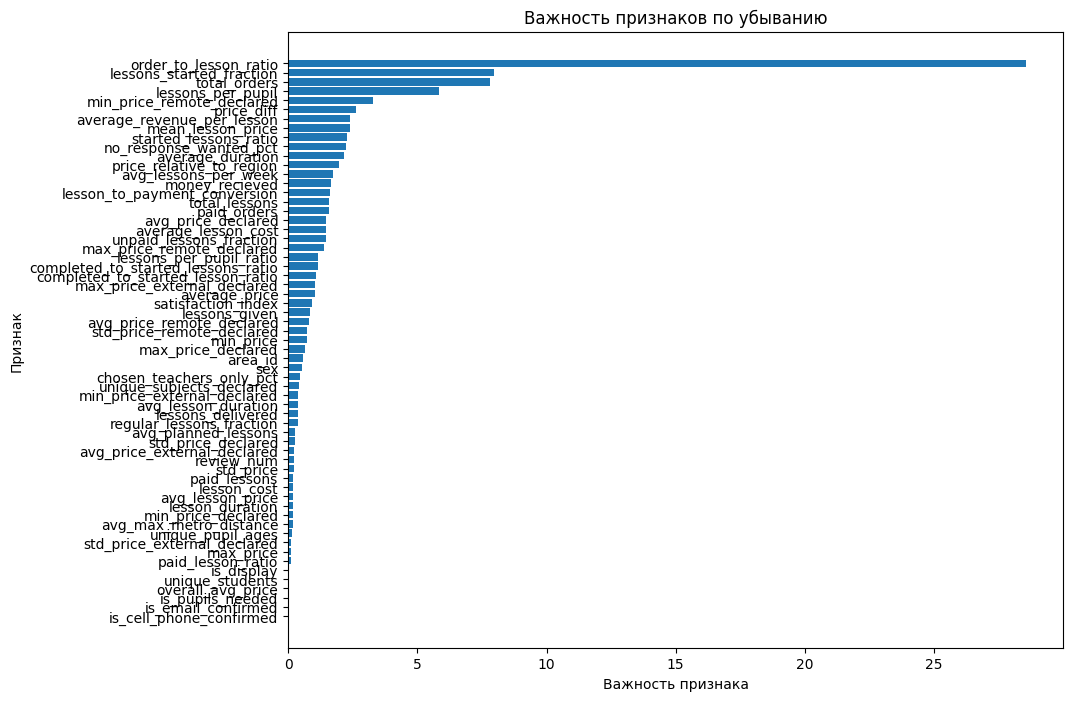

In [140]:
# Получение важности признаков
feature_importances = model.get_feature_importance()

# Создаем кортежи из важности признаков и их названий, затем сортируем их
features_sorted = sorted(zip(feature_importances, X.columns), reverse=False)

# Разделяем отсортированный список на важности и названия
sorted_importances, sorted_features = zip(*features_sorted)

# Визуализация отсортированной важности признаков
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков по убыванию')
plt.show()

Так как данные могут зашумлены большим количеством признаков,применим **permutation_importance** и отсеим ненужные 

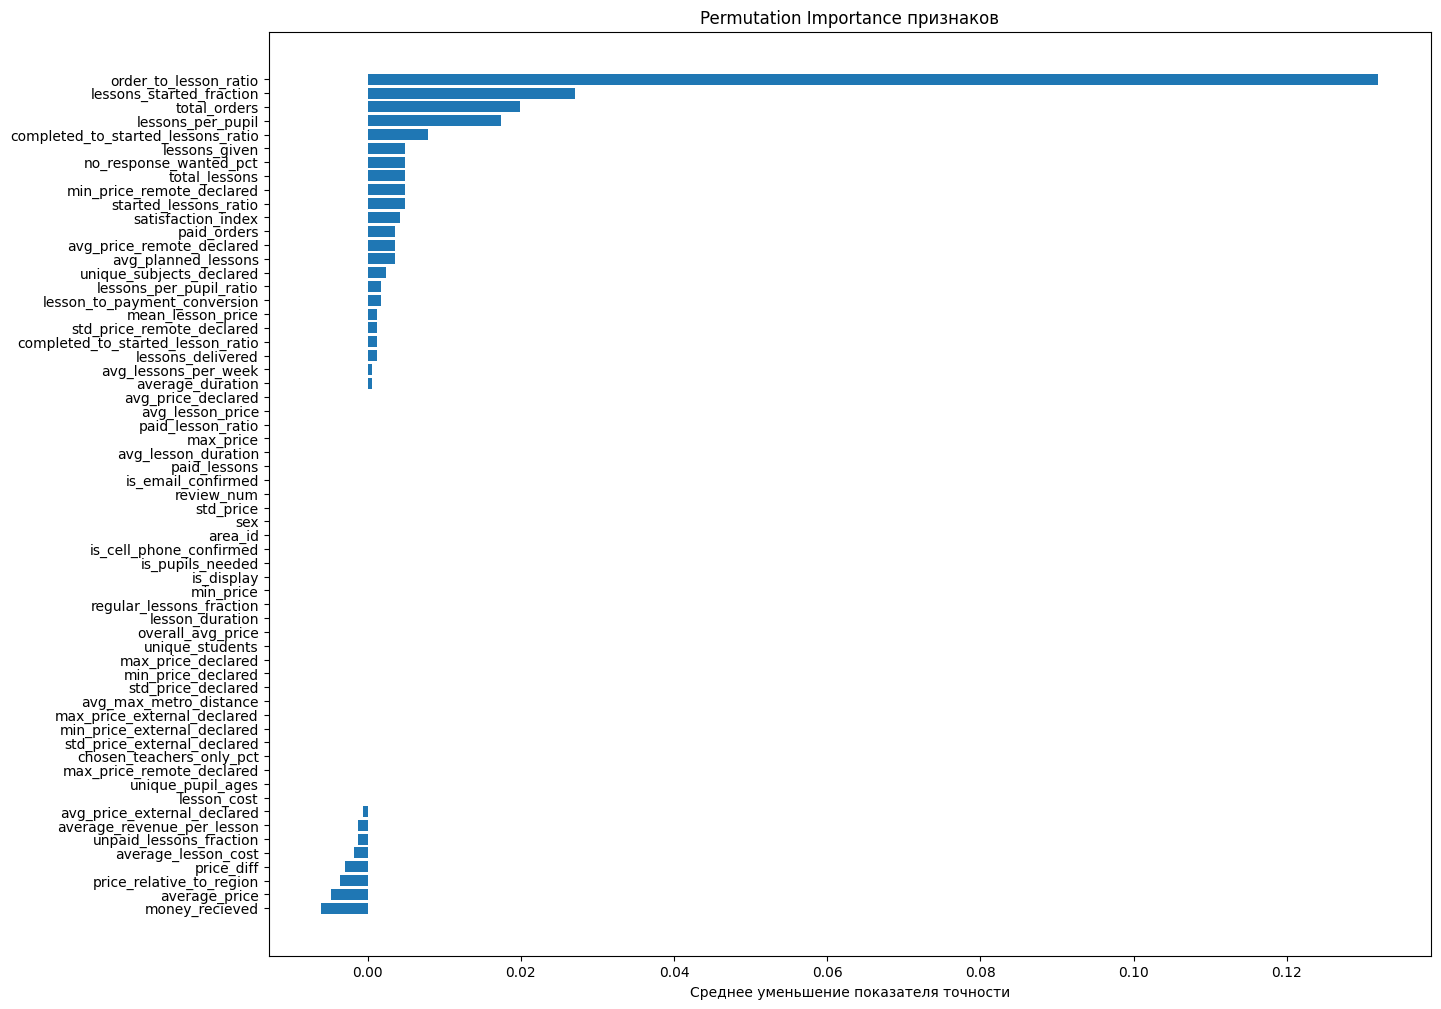

In [141]:
# Выполнение Permutation Importance на тестовом наборе
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=777, n_jobs=-1)

# Сортировка признаков по важности
sorted_idx = results.importances_mean.argsort()

# Подготовка данных для графика
sorted_importances = results.importances_mean[sorted_idx]
sorted_features = X_test.columns[sorted_idx]

# Визуализация
plt.figure(figsize=(15, 12))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), labels=sorted_features)
plt.xlabel('Среднее уменьшение показателя точности')
plt.title('Permutation Importance признаков')
plt.show()


In [142]:
# Определим порог важности. В данном случае, мы удалим все признаки с важностью <= 0
threshold = 0
low_importance_features = [feature for importance, feature in zip(results.importances_mean, X.columns) if importance <= threshold]

# Удалим неважные признаки
X_filtered = X.drop(low_importance_features, axis=1)


# Повторим разделение данных
X_train_filtered, X_temp_filtered, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.2, random_state=777)
X_valid_filtered, X_test_filtered, y_valid, y_test = train_test_split(X_temp_filtered, y_temp, test_size=0.5, random_state=777)

In [143]:
# Параметры модели с добавлением многоядерной обработки
params = {
    'iterations': 600,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'random_seed': 777,
    'verbose': 200,
    'l2_leaf_reg': 25,
    'auto_class_weights': 'Balanced',
}

# Создание Pool из отфильтрованных тренировочных данных
train_pool_filtered = Pool(X_train_filtered, y_train)

# Выполнение кросс-валидации на отфильтрованных тренировочных данных
cv_results_filtered = cv(
    pool=train_pool_filtered,
    params=params,
    fold_count=5,
    seed=777,
    shuffle=True,
    stratified=True,
    plot=True
)

# Выводим лучший результат F1-меры из результатов кросс-валидации
print(f'Лучшая F1-мера на кросс-валидации: {cv_results_filtered["test-F1-mean"].max()}')

# Обучаем модель на всем наборе отфильтрованных тренировочных данных
model_filtered = CatBoostClassifier(**params)
model_filtered.fit(X_train_filtered, y_train, eval_set=(X_valid_filtered, y_valid), use_best_model=True)

# Предсказания и расчет метрики на тестовом наборе для отфильтрованных данных
predictions_test_filtered = model_filtered.predict(X_test_filtered)
f1_test_filtered = f1_score(y_test, predictions_test_filtered)

print(f'F1-мера на тестовом наборе после удаления шумовых признаков: {f1_test_filtered}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7358225	test: 0.6891164	best: 0.6891164 (0)	total: 4.22ms	remaining: 2.53s
200:	learn: 0.8949452	test: 0.7644078	best: 0.7779461 (119)	total: 1.36s	remaining: 2.71s
400:	learn: 0.9721141	test: 0.7345754	best: 0.7779461 (119)	total: 2.27s	remaining: 1.12s
599:	learn: 0.9922590	test: 0.7184530	best: 0.7779461 (119)	total: 3.24s	remaining: 0us

bestTest = 0.7779461462
bestIteration = 119

Training on fold [1/5]
0:	learn: 0.7141666	test: 0.5694669	best: 0.5694669 (0)	total: 4.1ms	remaining: 2.45s
200:	learn: 0.8894174	test: 0.6744260	best: 0.6979046 (5)	total: 817ms	remaining: 1.62s
400:	learn: 0.9734718	test: 0.6348149	best: 0.6979046 (5)	total: 1.78s	remaining: 883ms
599:	learn: 0.9943443	test: 0.5992461	best: 0.6979046 (5)	total: 2.93s	remaining: 0us

bestTest = 0.6979046346
bestIteration = 5

Training on fold [2/5]
0:	learn: 0.7428944	test: 0.7471955	best: 0.7471955 (0)	total: 5.46ms	remaining: 3.27s
200:	learn: 0.8798063	test: 0.7773374	best: 0.79987

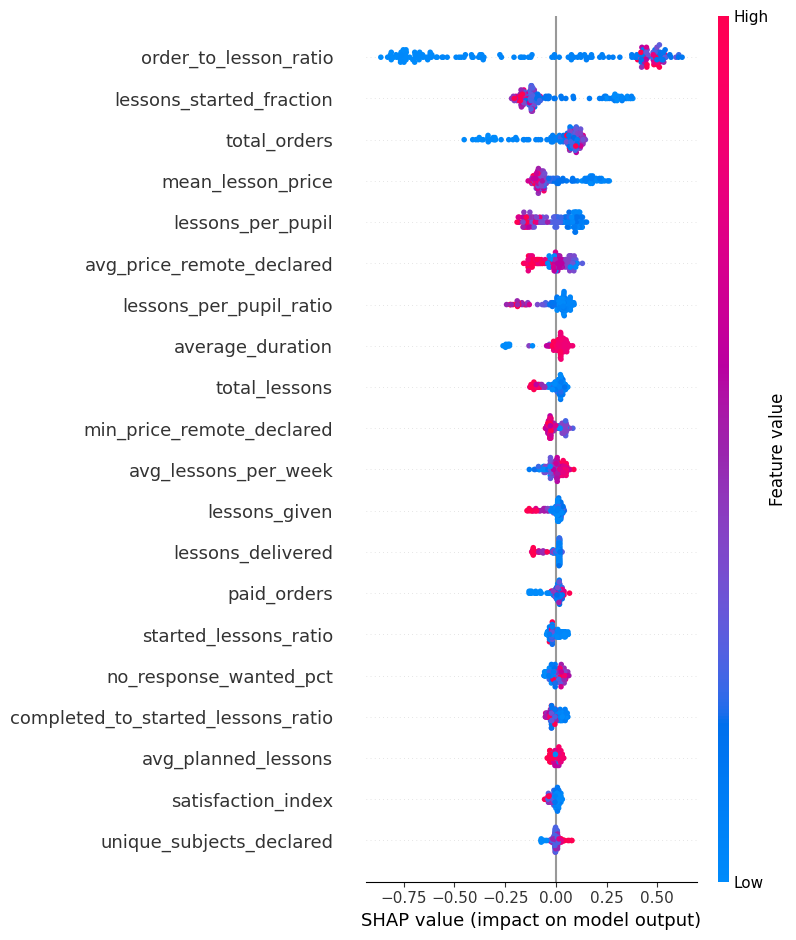

In [144]:
# Инициализация SHAP Explainer
explainer = shap.TreeExplainer(model_filtered)

# Вычисление SHAP значений для тестового набора данных
shap_values = explainer.shap_values(X_test_filtered)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test_filtered)

## Анализ важности признаков с использованием SHAP

SHAP (SHapley Additive exPlanations) предоставляет понимание вклада каждого признака в предсказание модели. Использование SHAP в контексте нашей задачи классификации неэффективных репетиторов дает следующие инсайты:

- **order_to_lesson_ratio**: Высокая важность этого признака может указывать на то, что соотношение между количеством заявок и проведенных уроков сильно влияет на классификацию репетитора.

- **lessons_started_fraction**: Регулярность начала уроков является ключевым фактором, влияющим на успешность репетитора. Этот признак может отражать надежность и стабильность в работе репетитора.

- **total_orders**: Общее количество заказов у репетитора также важно, подчеркивая факт, что более востребованные репетиторы могут быть более эффективными.

- **mean_lesson_price**: Стоимость урока влияет на классификацию, что может отражать взаимосвязь между ценой и качеством услуг репетитора.

- **lessons_per_pupil и lessons_per_pupil_ratio**: Эти показатели могут быть связаны с лояльностью учеников и их удовлетворенностью уроками.

- **average_duration и total_lessons**: Продолжительность уроков и их общее количество также играют значительную роль, что может указывать на то, что эффективность репетитора коррелирует с интенсивностью их работы.

- **avg_price_remote_declared и min_price_remote_declared**: Видимо, удаленные уроки и их стоимость особенно важны, что может быть связано с текущей тенденцией и предпочтениями учеников.

- **satisfaction_index**: Индекс удовлетворенности, который может быть вычислен как отношение отзывов к стоимости уроков, показывает влияние репутации репетитора на его классификацию.

- **unique_subjects_declared**: Разнообразие предметов, которые репетитор готов преподавать, может быть индикатором его гибкости и способности привлекать больше учеников.

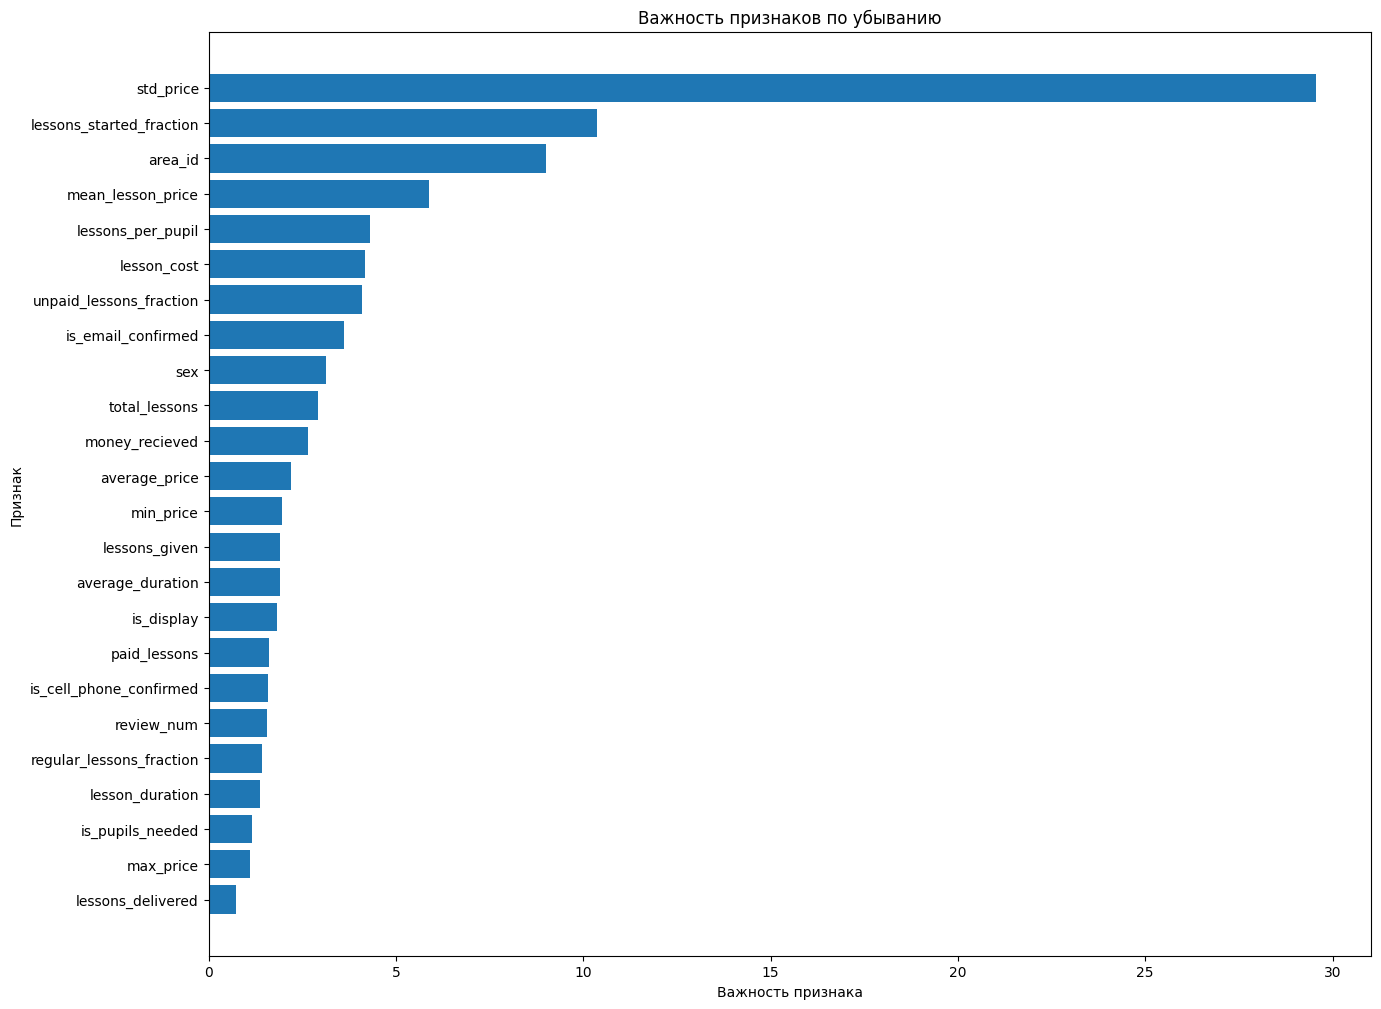

In [145]:
# Получение важности признаков
feature_importances = model_filtered.get_feature_importance()

# Создаем кортежи из важности признаков и их названий, затем сортируем их
features_sorted = sorted(zip(feature_importances, X.columns), reverse=False)

# Разделяем отсортированный список на важности и названия
sorted_importances, sorted_features = zip(*features_sorted)

# Визуализация отсортированной важности признаков
plt.figure(figsize=(15, 12))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков по убыванию')
plt.show()

## Анализ важности признаков для классификации репетиторов

- **std_price**: Вариативность цен может указывать на гибкость ценообразования репетитора или на его нестабильность, что влияет на его надёжность с точки зрения клиента.
  
- **lessons_started_fraction**: Процент начатых уроков отражает надёжность репетитора и его способность удерживать учеников.

- **area_id**: Регион преподавания, влияющий на доступность и предпочтения учеников, особенно в крупных городских или удалённых районах.

- **mean_lesson_price**: Средняя стоимость урока напрямую коррелирует с финансовыми ожиданиями репетитора и может влиять на его классификацию как 'платящего'.

- **lessons_per_pupil**: Количество уроков на ученика может сигнализировать о лояльности клиентов и их готовности продолжать обучение.

- **lesson_cost**: Стоимость урока может быть индикатором качества предоставляемых услуг или конкурентоспособности репетитора на рынке.

- **unpaid_lessons_fraction**: Высокий процент неоплаченных уроков может указывать на проблемы в эффективности или финансовой дисциплине репетитора.

Дополнительные признаки, вроде подтверждения e-mail, пола репетитора и общего количества уроков, хоть и менее значимы, могут дать дополнительный контекст для оценки и классификации репетиторов.


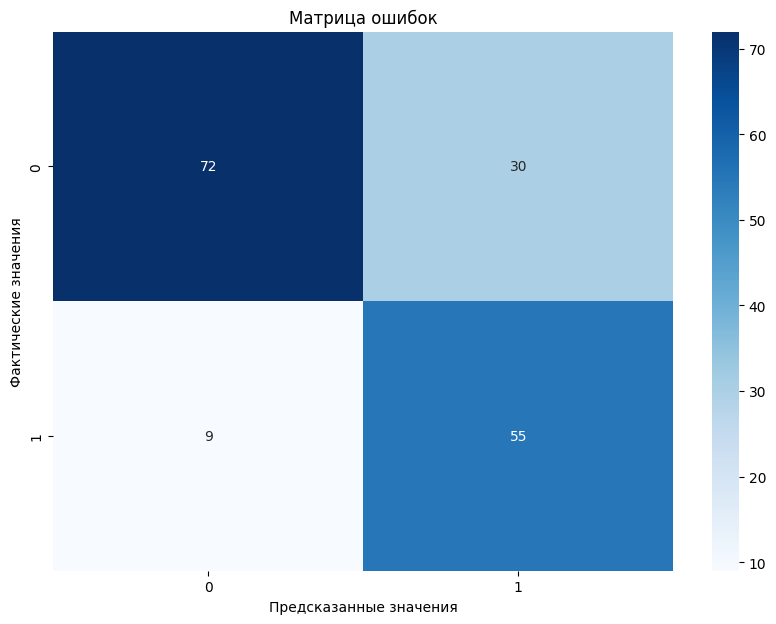

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       102
           1       0.65      0.86      0.74        64

    accuracy                           0.77       166
   macro avg       0.77      0.78      0.76       166
weighted avg       0.80      0.77      0.77       166



In [149]:
# Создание матрицы ошибок
cm = confusion_matrix(y_test, predictions_test_filtered)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок")
plt.ylabel("Фактические значения")
plt.xlabel("Предсказанные значения")
plt.show()
# Отчёт по классификации
print(classification_report(y_test, predictions_test_filtered))


In [150]:
# Найдем индексы ложноположительных и ложноотрицательных результатов
fp = (y_test == 0) & (predictions_test == 1)
fn = (y_test == 1) & (predictions_test == 0)
# Предсказание вероятностей для класса 1
probabilities_test_filtered = model_filtered.predict_proba(X_test_filtered)[:, 1]

# Определяем новый порог
threshold = 0.5 

# Получаем новые предсказания на основе порога
predictions_with_new_threshold = (probabilities_test_filtered >= threshold).astype(int)

# Расчет F1-меры с новым порогом
f1_with_new_threshold = f1_score(y_test, predictions_with_new_threshold)

print(f'F1-мера на тестовом наборе с стандартным порогом: {f1_with_new_threshold}')


fpr, tpr, thresholds = roc_curve(y_test, probabilities_test_filtered)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Оптимальный порог: {optimal_threshold}')

F1-мера на тестовом наборе с стандартным порогом: 0.738255033557047
Оптимальный порог: 0.5061118076066425


In [151]:
# Предсказание вероятностей для класса 1
probabilities_test_filtered = model_filtered.predict_proba(X_test_filtered)[:, 1]

# Определяем новый порог
threshold = optimal_threshold

# Получаем новые предсказания на основе порога
predictions_with_new_threshold = (probabilities_test_filtered >= threshold).astype(int)

# Расчет F1-меры с новым порогом
f1_with_new_threshold = f1_score(y_test, predictions_with_new_threshold)

print(f'F1-мера на тестовом наборе с новым порогом: {f1_with_new_threshold}')

F1-мера на тестовом наборе с новым порогом: 0.7432432432432432


Мне пока сложно интерпретировать результаты кода  ниже заказчику, так как сам ни разу не практиковал данный метод.

В общем, код ниже показывает, где модель ошибается, и с этими подсказками можно бороться на улучшение ее качества, либо создавать новые признаки в ошибочных, либо лучше подготавливать данные. Я его закомментировал, но кто будет проверять, может его посмотреть.

Так как я теперь, вроде, в роли старшего выпускника ЯП, у меня должна быть персональная обратная связь по проекту. Я хотел бы обсудить именно на примере данной задачи ошибки в модели и ее дальнейшее улучшение с использованием метода анализа ошибок, чтобы модель можно было применить на практике.

Я думаю, мой результат в 0.75 отличный, один из самых высоких должен быть. Изначально в первые дни решения задачи я ориентировался на то, что выше 0.74-0.77 прыгнуть нельзя, исходя из данных.

Думаю, ансамблем можно поднять пару процентов. Параметры я подбирал вручную (очень долго и мучительно, гридсерч и оптуна не дали нужных мне результатов).

In [34]:
# Перебираем все столбцы в X_test
#for column in X_test.columns:
#    plt.figure(figsize=(10, 5))
#    sns.histplot(X_test.loc[fp, column], color="red", label="False Positives", kde=True, stat="density")
#    sns.histplot(X_test.loc[fn, column], color="blue", label="False Negatives", kde=True, stat="density")
#    plt.title(f'Распределение признака: {column}')
#    plt.legend()
#    plt.show()
